In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
t_data = pd.read_csv('final_train_data.csv', usecols=['tokens', 'label'], encoding='utf-8')
v_data = pd.read_csv('final_valid_data.csv', usecols=['tokens', 'label'], encoding='utf-8')

In [8]:
t_data.head()  # train data

,label,tokens
0,9,"['아', '최고', 'ㅡ오프닝진짜진짜멋지고', '노래', '스카이폴', '저택',..."
1,3,"['중간', '에', '기분', '이', '너무', '불쾌', '하', '고', '..."
2,2,"['액션', '신', '이', '마치', '유치원', '생', '이', '칼싸움',..."
3,4,"['포스터', '보구', '완전', '낚', '인', '듯', '제목', '그대로'..."
4,9,"['시사회', '로', '보', '고', '왔', '는데요', '볼거리', '도',..."


In [9]:
v_data.head()  # validation data

,label,tokens
0,9,"['억지', '설정', '에', '눈물', '짜깁기', '한', '게', '아니',..."
1,10,"['보', '면서', '전혀', '억지', '라는', '생각', '이', '들', ..."
2,10,"['영화', '를', '보', '고', '평점', '등록', '하', '긴', '하..."
3,10,"['많', '은', '내용', '을', '담', '은', '영화', '배우', '들..."
4,8,"['경찰', '청장', '배역', '씹', '어', '먹', '을', '인간', '..."


In [10]:
# foramat data
# make labels 0~9

t_data['tokens'] = t_data['tokens'].apply(lambda x: eval(x))
t_data['label_re'] = t_data['label'].apply(lambda x: x-1)

v_data['tokens'] = v_data['tokens'].apply(lambda x: eval(x))
v_data['label_re'] = v_data['label'].apply(lambda x: x-1)

In [11]:
# make word vocabulary

total_words = []
for tokens in t_data['tokens']:
    total_words += tokens
    
word_set = set(total_words)

In [12]:
vocab = {word: i+2 for i, word in enumerate(word_set)}  # assign each word with a number
vocab['<unk>'] = 1
vocab['<pad>'] = 0

In [13]:
len(word_set)  # total words

43027

In [14]:
len(vocab.keys())

43029

In [15]:
# encode tokens

def encode(tokens, vocab2index):
    encoded = np.zeros(40, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["<unk>"]) for word in tokens])
    if len(enc1) > 40:
        encoded = enc1[:40]
    else:
        length = len(enc1)
        encoded[:length] = enc1[:length]
    return encoded

In [16]:
# apply encoding

t_data['encoded'] = t_data['tokens'].apply(lambda x: encode(x, vocab))
v_data['encoded'] = v_data['tokens'].apply(lambda x: encode(x, vocab))

In [17]:
t_data.head()

,label,tokens,label_re,encoded
0,9,"[아, 최고, ㅡ오프닝진짜진짜멋지고, 노래, 스카이폴, 저택, 장면, 도, 최고, ...",8,"[14296, 279, 22526, 26237, 30925, 18122, 2314,..."
1,3,"[중간, 에, 기분, 이, 너무, 불쾌, 하, 고, 역겨워서, 나가, 고, 싶, 은...",2,"[22961, 2189, 23734, 10770, 14910, 16647, 2406..."
2,2,"[액션, 신, 이, 마치, 유치원, 생, 이, 칼싸움, 하, 는, 것, 과, 비슷,...",1,"[2985, 11413, 10770, 33909, 35052, 21105, 1077..."
3,4,"[포스터, 보구, 완전, 낚, 인, 듯, 제목, 그대로, 뭔가, 암울, 한, 이야기...",3,"[14671, 4248, 1396, 40358, 5080, 28036, 7080, ..."
4,9,"[시사회, 로, 보, 고, 왔, 는데요, 볼거리, 도, 많, 고, 캐릭터, 도, 완...",8,"[1282, 37459, 649, 42295, 2557, 28973, 11749, ..."


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [29]:
batch_size = 128
learning_rate = 0.001
num_epoch = 300

In [20]:
vocab_size = len(vocab.keys())
embedding_dim = 300
hidden_dim = 128

In [21]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

In [22]:
train_ds = ReviewsDataset(t_data['encoded'], t_data['label_re'])
train_ld = DataLoader(train_ds, batch_size=batch_size, num_workers=2)

In [23]:
valid_ds = ReviewsDataset(t_data['encoded'], t_data['label_re'])
valid_ld = DataLoader(valid_ds, batch_size=batch_size, num_workers=2)

In [24]:
class LSTM_stacked(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim,hidden_dim)
        self.dropout = nn.Dropout(0.4)
        self.fc_layer = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Softmax(dim=1))
    
    def forward(self, x):
        out = self.embeddings(x)
        out, (ht, ct) = self.lstm1(out)
        out = self.dropout(out)
        out, (ht, ct) = self.lstm2(out)
        out = out[:,-1, :]
        out = self.fc_layer(out)
        return out

In [25]:
torch.cuda.is_available()

True

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM_stacked(vocab_size, embedding_dim, hidden_dim).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
loss_arr = []
for i in range(num_epoch):
    for j, [text, label] in enumerate(train_ld):
        x = text.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
            loss_arr.append(loss.cpu().detach().numpy())
 
    print('epoch : {}'.format(i+1))

epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
epoch : 10
epoch : 11
epoch : 12
epoch : 13
epoch : 14
epoch : 15
epoch : 16
epoch : 17
epoch : 18
epoch : 19
epoch : 20
epoch : 21
epoch : 22
epoch : 23
epoch : 24
epoch : 25
epoch : 26
epoch : 27
epoch : 28
epoch : 29
epoch : 30
epoch : 31
epoch : 32
epoch : 33
epoch : 34
epoch : 35
epoch : 36
epoch : 37
epoch : 38
epoch : 39
epoch : 40
epoch : 41
epoch : 42
epoch : 43
epoch : 44
epoch : 45
epoch : 46
epoch : 47
epoch : 48
epoch : 49
epoch : 50
epoch : 51
epoch : 52
epoch : 53
epoch : 54
epoch : 55
epoch : 56
epoch : 57
epoch : 58
epoch : 59
epoch : 60
epoch : 61
epoch : 62
epoch : 63
epoch : 64
epoch : 65
epoch : 66
epoch : 67
epoch : 68
epoch : 69
epoch : 70
epoch : 71
epoch : 72
epoch : 73
epoch : 74
epoch : 75
epoch : 76
epoch : 77
epoch : 78
epoch : 79
epoch : 80
epoch : 81
epoch : 82
epoch : 83
epoch : 84
epoch : 85
epoch : 86
epoch : 87
epoch : 88
epoch : 89
epoch : 90
epoch : 91
epoch : 

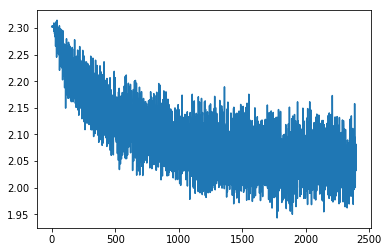

In [32]:
# loss

plt.plot(loss_arr)
plt.show()

In [33]:
# model test

correct = 0
total = 0

with torch.no_grad():
    for text, label in valid_ld:
        x = text.to(device)
        y = label.to(device)

        output = model.forward(x)
        _, output_index = torch.max(output,1)

        total += label.size(0)
        correct += (output_index == y).sum().float()
    print('Accuracy of Test Data: {}'.format(correct/total))

Accuracy of Test Data: 0.3803499937057495


In [2]:
!nvidia-smi

Thu Sep 10 01:27:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    78W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

Available devices  1
Current cuda device  0
Tesla K80
